# Ursa Major Proper Motion - Animation Stills

Animate proper motions for the field of Ursa Major (aka Big Dipper) using data from Gaia DR3.  We generate
the individual frames as PNG files then combine them offline (e.g., in iMovie or with ffmpeg) into video
files.

I used `ffmpeg` to assembly the PNG format still frames into the core video file:

 > `ffmpeg -framerate 15 -i UMa_PM_%03d.png ../video.mp4`

You can then read `video.mp4` into an app like `iMovie` to edit, add intro/outro frames, and export in
whatever format you want.

See the `Gaia_DR3_UMa.ipynb` notebook which shows how current and arbitrary epoch plotting is done.  We
use the methods from that notebook run in a loop to animate the proper motions.

### Notes

Based on the Gaia Archive tutorial (located at the Gaia Archive, http://archives.esac.esa.int/gaia -> Help -> Tutorials -> Cluster analysis ) and adapted it to python.
The tutorial uses the Gaia TAP+ (astroquery.gaia) module, http://astroquery.readthedocs.io/en/latest/gaia/gaia.html#module-astroquery.gaia 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd

import math
import time

# astropy for coordinates and units

from astropy.coordinates import SkyCoord, Distance
from astropy.time import Time

from astropy import units as u
from astropy.units import Quantity

# astroquery for Gaia and TAP+

from astroquery.gaia import Gaia
from astroquery.utils.tap import TapPlus

# Suppress nuisance warnings

import warnings
warnings.filterwarnings('ignore')

## Plot setup

Frames are rendered in 4K UHD format, 3840x2160 pixels at 150dpi


In [2]:
# format: 4K UHD 3840x2160 at 100dpi

dpi = 150
wDisp = 3840
hDisp = 2160
wInches = float(wDisp)/float(dpi)
hInches = float(hDisp)/float(dpi)
aspect = wDisp/hDisp

# default font size

fontSize = 16
matplotlib.rcParams.update({'font.size':fontSize})

matplotlib.rcParams['xtick.major.pad']=0
matplotlib.rcParams['ytick.major.pad']=0
matplotlib.rcParams['axes.labelpad']=0

## Gaia data query

Perform an asynchronous query centered on the nominal field center of UMa (`dRA` and `dDec`) with a search
radius of `searchRad` degrees.

Note: The query to the archive is with ADQL (Astronomical Data Query Language). For a description of ADQL and more examples see the Gaia DR1 ADQL cookbook: https://gaia.ac.uk/data/gaia-data-release-1/adql-cookbook

Search limits:
 * g mag between 3.0 and 10.0mag
 * error in proper motions <10%
 * stars with valid parallaxes and proper motions (not null or parallax <=0)
 
A typical query can be as fast as 10 seconds or as slow as 60 seconds, depending on the internet
connection and server load downstream.  We time it.

In [3]:
# Gaia Tables

tables = Gaia.load_tables(only_names=True)

# UMa field center and radius in decimal degrees

dRA = 186.17
dDec = 56.5
searchRad = 15.0*math.sqrt(2)

# magnitude limits

faintMag = 10.0
brightMag = 3.0

# ADQL query string

gQuery=f"""
SELECT *
FROM gaiadr3.gaia_source
WHERE CONTAINS(POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),CIRCLE('ICRS',{dRA},{dDec},{searchRad}))=1
AND phot_g_mean_mag BETWEEN {brightMag:.1f} and {faintMag:.1f}
AND abs(pmra_error/pmra)<0.10
AND abs(pmdec_error/pmdec)<0.10
AND parallax IS NOT NULL AND parallax>0
AND pmra IS NOT NULL AND abs(pmra)>0
AND pmdec IS NOT NULL AND abs(pmdec)>0
"""

#print(gQuery)

print('Launching Gaia DR3 query...')

t0 = time.time()
job = Gaia.launch_job_async(gQuery)
j = job.get_results()
dt = time.time() - t0

print(f'Retrieved {len(j)} stars, query took {dt:.1f} seconds')

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]
Launching Gaia DR3 query...
INFO: Query finished. [astroquery.utils.tap.core]
Retrieved 7624 stars, query took 15.0 seconds


### Process Gaia query results

extract in RA, Dec, parallax, proper motions (RA and Dec), gMag and epoch for each star.

#### star brightness

An old trick from star catalogs is to represent star brightness in magnitudes by the size (area) of the
point.  There are lots of ways to do this, all quite arbitrary.  This is the one that I find gives good
results with the plot size (pixels and dpi) that I'm using.  Your mileage may vary.
\begin{equation}
    ms = 2 \left((mag_{faint}+0.05) - mag\right)\times\left(\frac{100}{dpi}\right)
\end{equation}
$mag_{faint}+0.05$ is chosen so that stars at our limiting faint magnitude ($mag_{faint}$) are plotted as
the smallest visible point size.


In [5]:
ra = np.array(j['ra'])
dec = np.array(j['dec'])
parallax = np.array(j['parallax'])
pmra = np.array(j['pmra'])
pmdec = np.array(j['pmdec'])
gMag = np.array(j['phot_g_mean_mag'])
epoch = np.array(j['ref_epoch'])

# algorithm for magnitude point-size scaling, baseline is 100 dpi

ms = 2.0*((faintMag+0.05) - gMag)*(100/dpi) 

gaiaEpoch = epoch[0]

numStars = len(j)
print(f'Number of stars: {numStars}')
print(f'magnitude range: {np.min(gMag):.2f} to {np.max(gMag):.2f}')
print(f'Gaia DR3 Epoch {gaiaEpoch:.2f}')

Number of stars: 7624
magnitude range: 3.10 to 10.00
Gaia DR3 Epoch 2016.00


## Bright Stars

These are the bright stars that define the Big Dipper constellation, we don't sketch out the complete
Big Bear constellation for this animation.

We got these coordinates from a combination of Gaia DR3 for the fainter stars, and Hipparcos for the stars
brigher than the Gaia DR3 limit. 

Use the same brightness representation as above.

In [6]:
umaFile = 'UMa_Bright.cat'
data = pd.read_csv(umaFile,sep=r'\s+',comment='#')

raUMa = np.array(data['ra'])
decUMa = np.array(data['dec'])
parUMa = np.array(data['par'])
pmrUMa = np.array(data['pmra'])
pmdUMa = np.array(data['pmdec'])
magUMa = np.array(data['vMag'])
epUMa = np.array(data['epoch'])
srcUMa = np.array(data['source'])

# algorithm for representing magnitude by the size of the point drawn.

msUMa = 2.0*((faintMag+0.05) - magUMa)*(100/dpi)

# full coordinate object for the UMa constellation stars

const = SkyCoord(ra=raUMa*u.deg,dec=decUMa*u.deg,
                 distance=Distance(parallax=parUMa*u.mas),
                 pm_ra_cosdec=pmrUMa*u.mas/u.yr,
                 pm_dec=pmdUMa*u.mas/u.yr,
                 obstime=Time(epUMa,format='decimalyear'),
                 frame='icrs')

# Transform into the Gaia epoch

constel = const.apply_space_motion(Time(gaiaEpoch,format='decimalyear'))

## Transform to ($\xi,\eta$) coordinates

Transform to "offset" ($\xi,\eta$) coordinates (aka "standard coordinates on the tangent plane") for plotting

In [7]:
# coordinate object for the nominal field center

uma = SkyCoord(dRA*u.deg,dDec*u.deg,frame='icrs')

# full coordinate object for all the stars

stars = SkyCoord(ra=ra*u.deg,
                 dec=dec*u.deg,
                 distance=Distance(parallax=parallax*u.mas,allow_negative=True),
                 pm_ra_cosdec=pmra*u.mas/u.yr,
                 pm_dec=pmdec*u.mas/u.yr,
                 obstime=Time(epoch,format='decimalyear'),
                 frame='icrs')

# Transform field to (xi,eta) coords centered on UMa

skyView = stars.transform_to(uma.skyoffset_frame())
xi = skyView.lon
eta = skyView.lat

# and same for the constellation proper

conUMa = constel.transform_to(uma.skyoffset_frame())
xiUMa = conUMa.lon
etaUMa = conUMa.lat

## View Today

Make a single-frame image of the field of the Big Dipper as it appears today (Gaia DR3 Epoch).

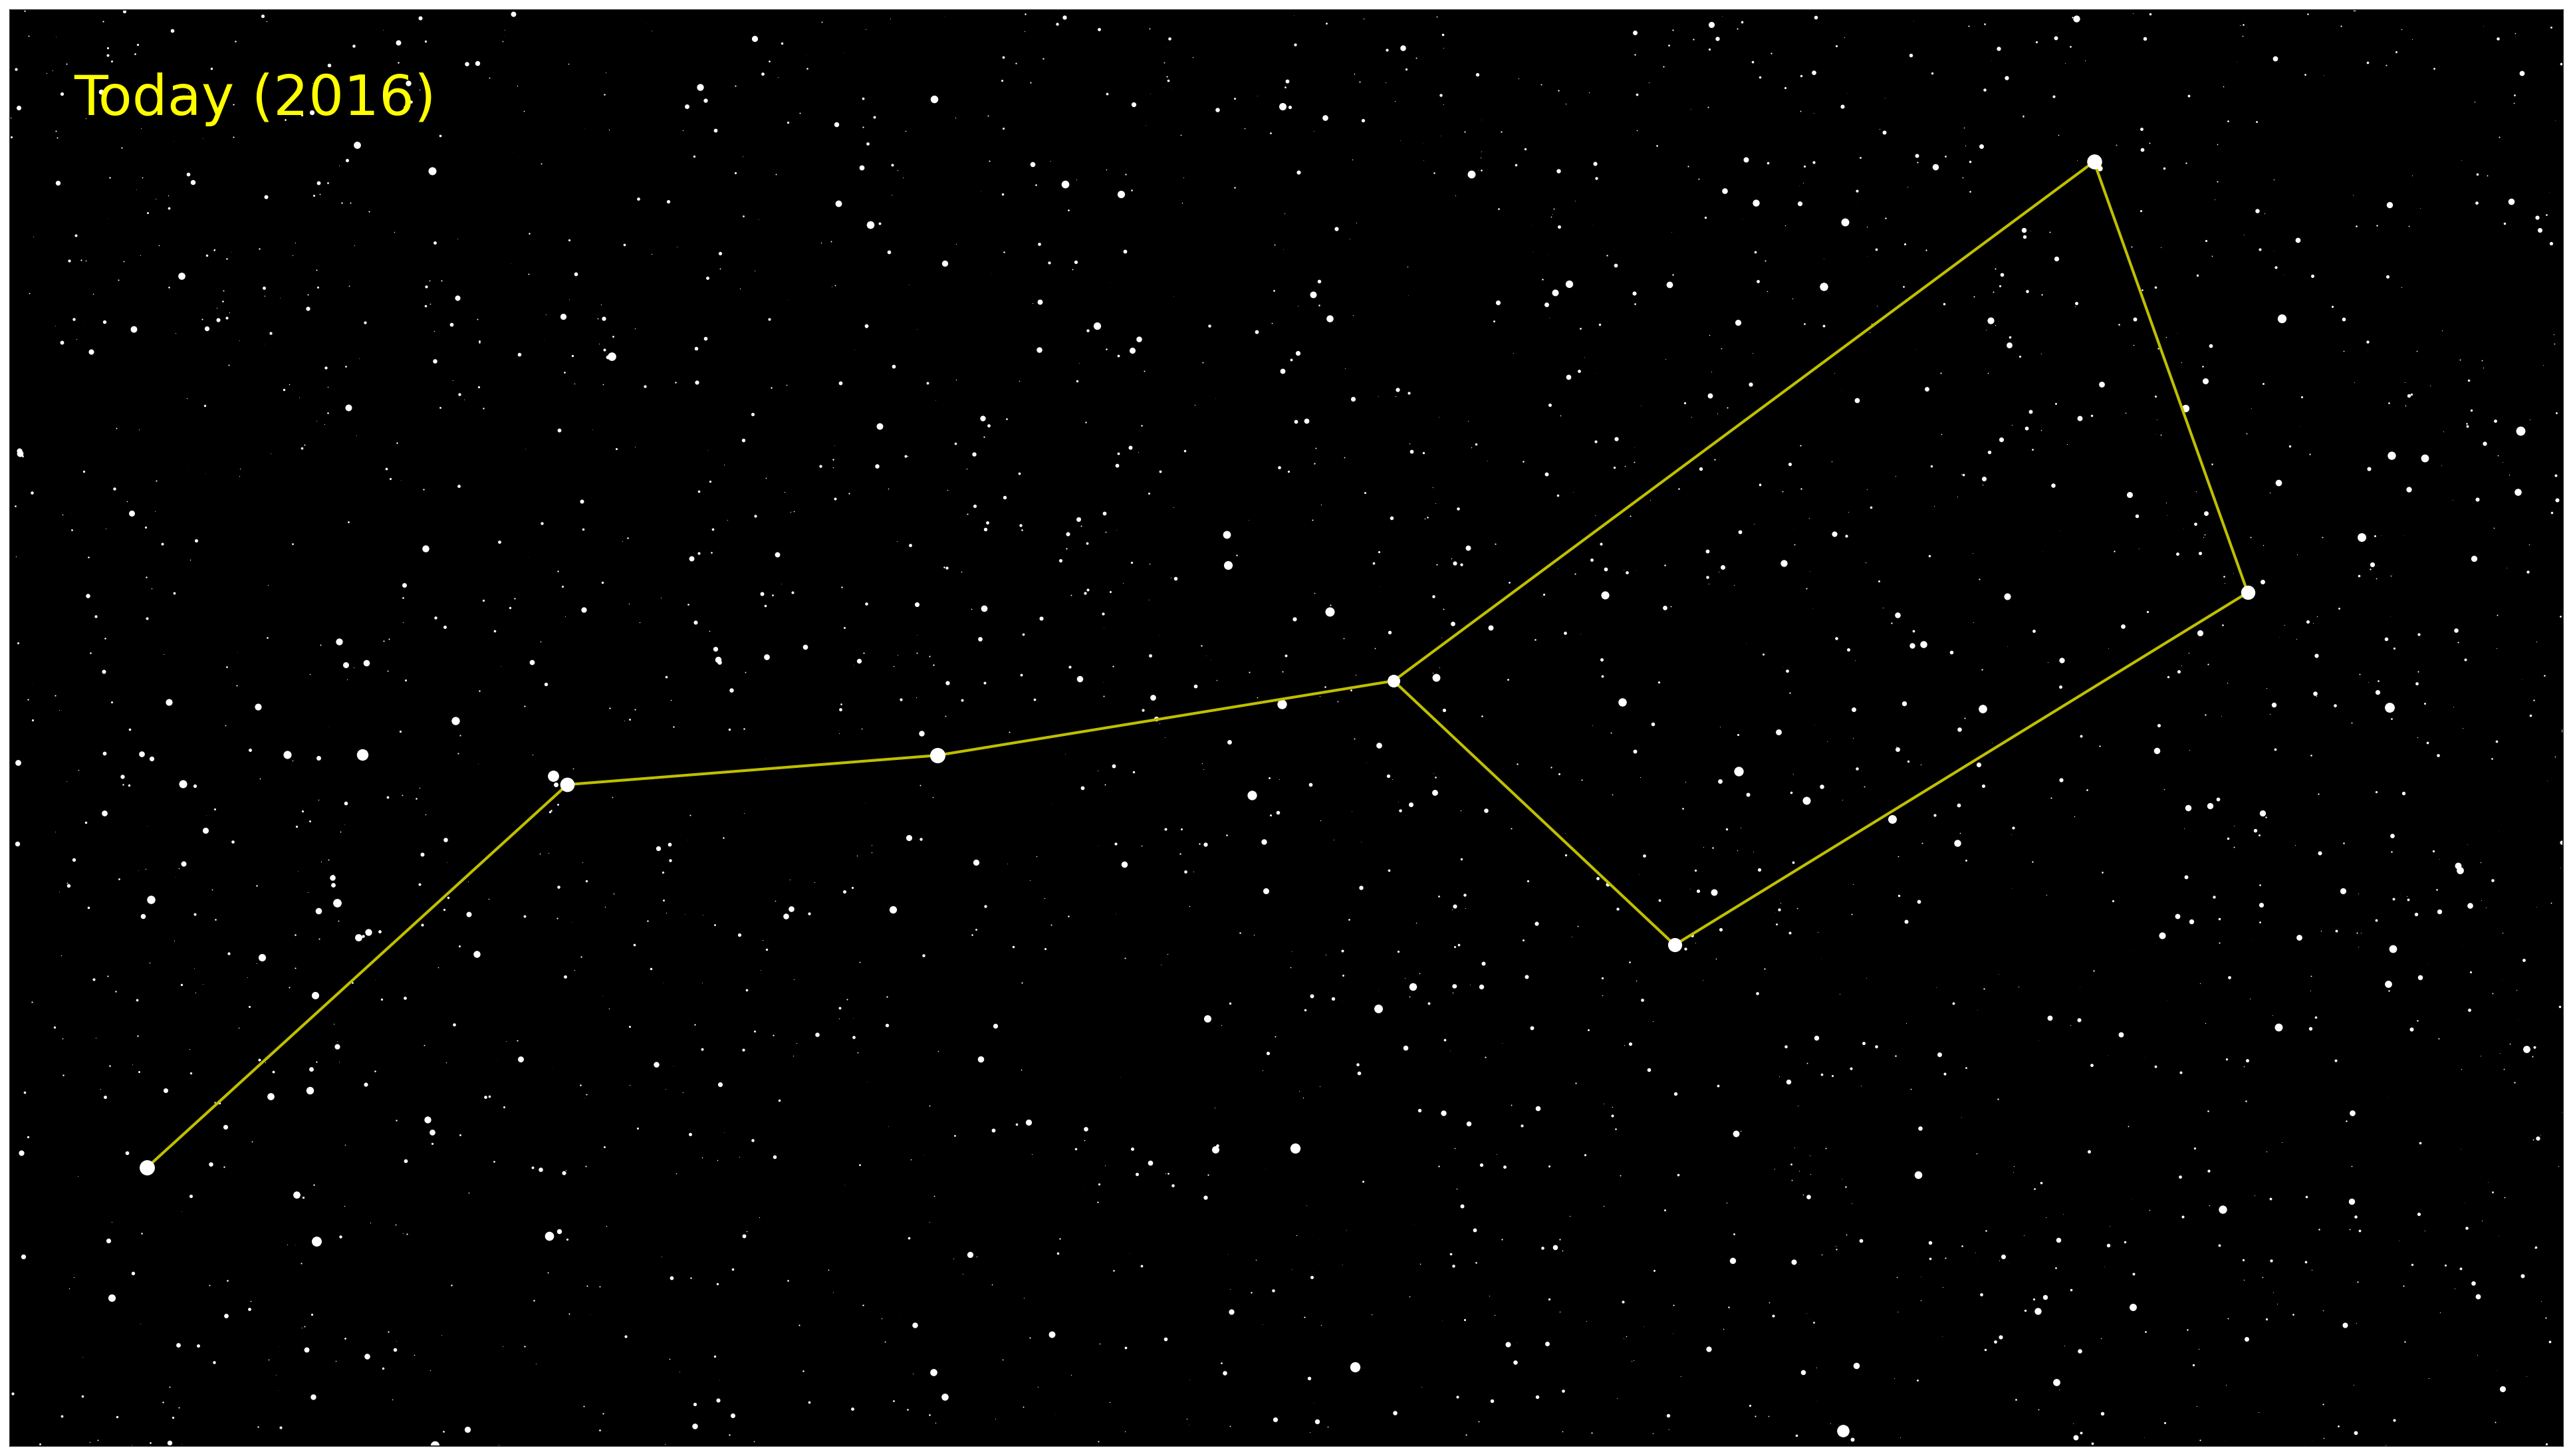

In [8]:
fig,ax = plt.subplots(figsize=(wInches,hInches),dpi=dpi)

ax.set_position([0, 0, 1, 1])
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor('black')

halfWidth = 15
ax.set_xlim(halfWidth,-halfWidth)
ax.set_ylim(-halfWidth/aspect,halfWidth/aspect)

for i in range(len(xi)):
    ax.plot(xi[i],eta[i],color='white',alpha=1,marker='o',ms=ms[i],mew=0)

for i in range(len(xiUMa)-1):
    ax.plot(xiUMa[i],etaUMa[i],color='white',alpha=1,marker='o',ms=msUMa[i],mew=0,zorder=10)
    
ax.plot(xiUMa,etaUMa,'y-',lw=2)

# Label

xlab = 0.95*halfWidth
ylab = 0.875*halfWidth/aspect
ax.text(xlab,ylab,f"Today ({int(gaiaEpoch)} AD)",fontsize=40,color='yellow',va='center',ha='left',zorder=10)

# Plot and save

fig.savefig('UMa_GaiaDR3_Today.png',bbox_inches='tight',pad_inches=0.0)

plt.show()

## Generate the individual frames as standalone files.

Runs from 4000BC to 130k AD in 1000 year steps making PNG still for each frame in the `Frames` folder.  This
generates 135 frames.  At 15 frames/sec that would be 9 seconds of video.

We cannot go earlier than 4799BC with the `astropy.time` module (sorry).

Frames are numbered from `001` thru `nnn`.

This is admittedly brute force, but it lets us break the movie rendering out of python and use better graphics
tools like `ffmpeg`.

In [ ]:
startEp = -4000.0 # 4000 BC
stopEp = 130000.0 # 130k AD
timeStep = 1000.0 # 1000 years per frame

numFrames = 1 + int((stopEp - startEp)/timeStep)

for iFrame in range(numFrames):
    t0 = time.time()
    viewEpoch = startEp + iFrame*timeStep
    if viewEpoch > 0:
        era = 'AD'
    elif viewEpoch < 0:
        era = 'BC'
    else:
        era = '1AD'

    pngFile = f'Frames/UMa_PM_{iFrame+1:03d}.png'

    if viewEpoch == 0:
        viewLabel = f'1 AD'
    else:
        viewLabel = f'{int(abs(viewEpoch))} {era}'

    newEpoch = Time(viewEpoch,format='decimalyear')

    newStars = stars.apply_space_motion(newEpoch)
    newConst = constel.apply_space_motion(newEpoch)

    # Transform field to (xi,eta) coords centered on UMa

    sky = newStars.transform_to(uma.skyoffset_frame())
    xiSky = sky.lon
    etaSky = sky.lat

    # and same for the constellation proper

    conUMa = newConst.transform_to(uma.skyoffset_frame())
    xiUMa = conUMa.lon
    etaUMa = conUMa.lat

    # and plot it

    fig,ax = plt.subplots(figsize=(wInches,hInches),dpi=dpi)
    ax.set_position([0, 0, 1, 1])
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_facecolor('black')

    halfWidth = 15
    ax.set_xlim(halfWidth,-halfWidth)
    ax.set_ylim(-halfWidth/aspect,halfWidth/aspect)

    for i in range(len(xiSky)):
        ax.plot(xiSky[i],etaSky[i],color='w',alpha=1,marker='o',markersize=ms[i],mew=0)

    for i in range(len(xiUMa)-1):
        ax.plot(xiUMa[i],etaUMa[i],color='w',alpha=1,marker='o',markersize=msUMa[i],mew=0,zorder=10)
    
    ax.plot(xiUMa,etaUMa,'y-',lw=1)

    # Label

    xlab = 0.95*halfWidth
    ylab = 0.875*halfWidth/aspect
    ax.text(xlab,ylab,viewLabel,fontsize=36,color='yellow',va='center',ha='left',zorder=10)

    # show and save the plot

    fig.savefig(pngFile,bbox_inches='tight',pad_inches=0.0)

    dt = time.time() - t0
    print(f'Created frame {iFrame+1:03d}: {viewLabel} [{dt:.1f} sec]')
    
print(f'Done.')